In [1]:
import pandas as pd
import pyflux as pf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df = pd.read_excel("311 Team 7- MMR Surprises.xlsx", sheetname="MMR Surprises")
cols = df.columns.tolist()
cols = [elem for elem in cols if "Unnamed" not in elem]
df = df[cols]
df.head()

,Agency,MMR_Goal,Critical,Performance_Indicator,FY13,FY14,FY15,FY16,FY17,TGT17,TGT18,Column_5_Yr_Trend,Desired_Direction
0,ACS,1a,True,Average child protective specialist caseload,8.2,9.8,10.5,10.6,12.4,12,12,Up,Down
1,ACS,1c,True,"Number of moves in foster care per 1,000 care ...",1.3,1.4,1.5,1.4,1.5,1.4,1.4,Up,Down
2,ACS,1c,True,Children maltreated during family foster care ...,3.9,3.1,4,5.2,7.6,4.2,5,Up,Down
3,ACS,3a,True,Abscond rate in non-secure detention (average ...,0.05,0.08,0.05,0.03,0.08,0.03,0.05,Neutral,Down
4,ACS,3a,True,Youth on youth assaults and altercations with ...,0.34,0.35,0.3,0.39,0.38,0.35,0.35,Up,Down


In [107]:
def inject_nans(number):
    return [np.nan for _ in range(number)]

def inject_dates(year, start_month, end_month):
    end_month += 1
    return [datetime(year, month, 1) for month in range(start_month, end_month)]
    
def create_timeseries_frame(row):
    values = inject_nans(8) + [row["FY13"]] + inject_nans(3)
    values += inject_nans(8) + [row["FY14"]] + inject_nans(3)
    values += inject_nans(8) + [row["FY15"]] + inject_nans(3)
    values += inject_nans(8) + [row["FY16"]] + inject_nans(3) 
    values += inject_nans(8) + [row["FY17"]]
    time = inject_dates(2013, 1, 8) + [datetime(2013,9,1)] + inject_dates(2013, 10, 12)
    time += inject_dates(2014, 1, 8) + [datetime(2014, 9, 1)] + inject_dates(2014, 10, 12)
    time += inject_dates(2015, 1, 8) + [datetime(2015, 9, 1)] + inject_dates(2015, 10, 12)
    time += inject_dates(2016, 1, 8) + [datetime(2016, 9, 1)] + inject_dates(2016, 10, 12)
    time += inject_dates(2017, 1, 8) + [datetime(2017, 9, 1)]
    dicter = {
        "values": values,
        "time": time 
    }
    df = pd.DataFrame(dicter)
    return df.interpolate()

In [3]:
def create_timeseries_frame(row):
    dicter = {
        "values":[row["FY13"], np.nan, row["FY14"], np.nan, row["FY15"], np.nan, row["FY16"], np.nan, row["FY17"]],
        "time": [datetime(2013,1,1), datetime(2013, 6, 1), datetime(2014, 1, 1), datetime(2014, 1, 1), datetime(2015, 1, 1), datetime(2015, 6, 1), datetime(2016, 1, 1), datetime(2016, 6, 1), datetime(2017, 1, 1)]
    }
    df = pd.DataFrame(dicter)
    return df.interpolate()
    
    

In [4]:
agency_list = set(df["Agency"])
agency_level = {}.fromkeys(agency_list, {})
for index in df.index:
    agency_level[df.ix[index]["Agency"]][df.ix[index]["Performance_Indicator"]] = create_timeseries_frame(df.ix[index])

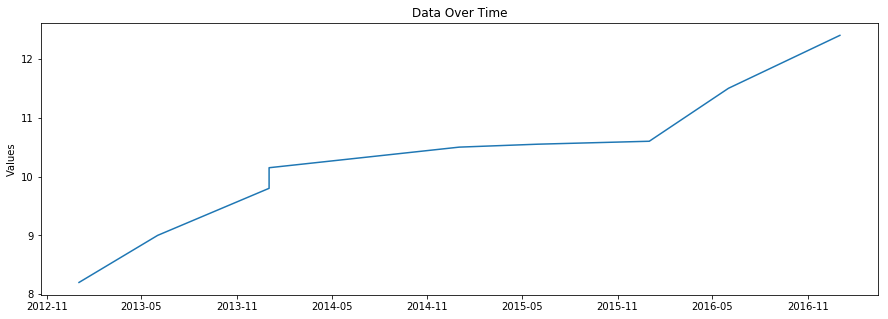

In [5]:
agency = list(agency_level.keys())[0]
performance_outcome = list(agency_level[agency].keys())[0]

data = agency_level[agency][performance_outcome]

data.index = data['time'].values

plt.figure(figsize=(15,5))
plt.plot(data.index,data['values'])
plt.ylabel('Values')
plt.title('Data Over Time')
plt.show()

In [17]:
model = pf.ARIMA(data=data,ar=3,ma=0,integ=0,target='values')

In [18]:
x = model.fit("MLE")
x.summary()

Normal ARIMA(3,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: values                              Method: MLE                                       
Start Date: 2014-01-01 00:00:00                         Log Likelihood: -0.4196                           
End Date: 2017-01-01 00:00:00                           AIC: 10.8392                                      
Number of observations: 6                               BIC: 9.798                                        
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 2.6529     5.1459     0.5155   0.6062   (-7.4331 | 12.7388)      
AR(1)                                

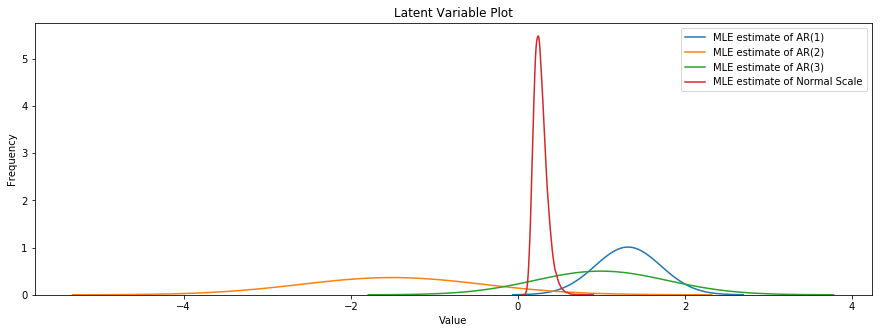

In [19]:
model.plot_z(indices=range(1,5))

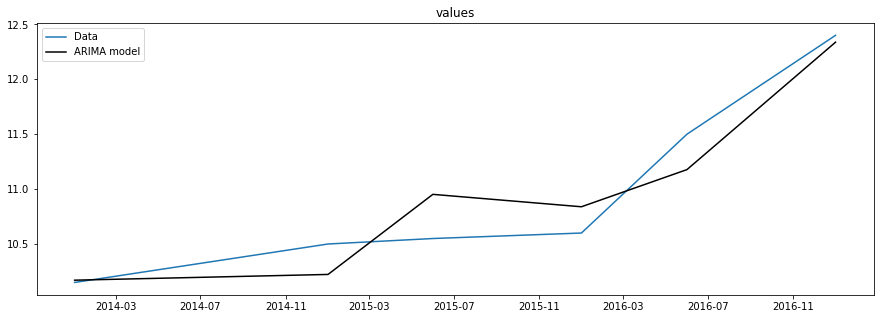

In [20]:
model.plot_fit(figsize=(15,5))

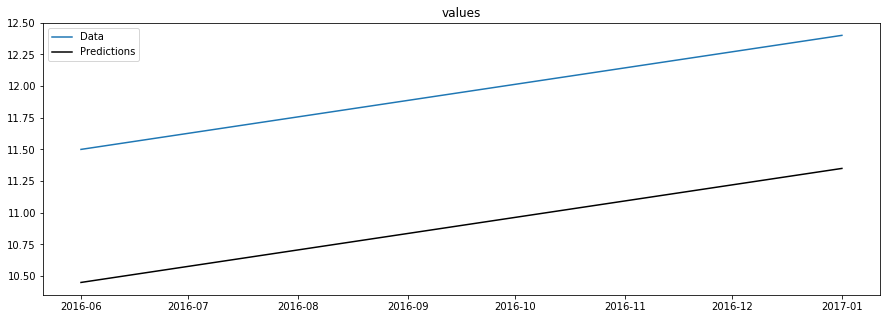

In [21]:
model.plot_predict_is(2,figsize=(15,5))

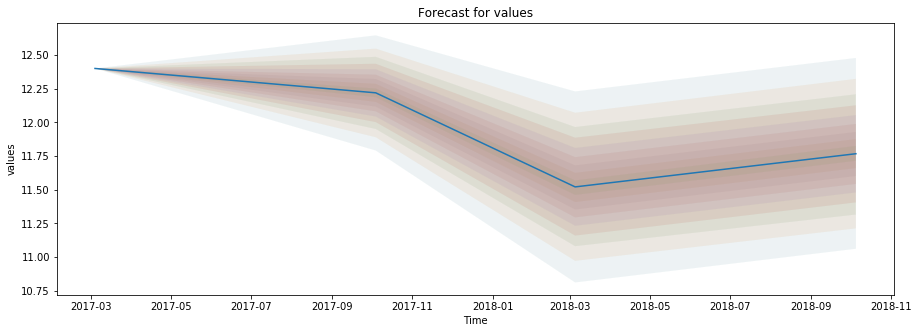

In [22]:
model.plot_predict(h=3,past_values=1,figsize=(15,5))

In [12]:
model.predict(h=3)

,values
2017-10-04,4.925462
2018-03-05,-2.548682
2018-10-05,64.509851
